In [1]:
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from functools import lru_cache
from pymorphy2 import MorphAnalyzer

# Сегодня мы обрабатываем текстовые комментарии к отелям и попробуем предсказывать их рейтиг (не комментариев)

In [2]:
df = pd.read_csv("train.csv", encoding="ISO-8859-1")

In [3]:
df

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2351 non-null   int64  
 1   Hotel_name    2351 non-null   object 
 2   Review_Title  2136 non-null   object 
 3   Review_Text   2351 non-null   object 
 4   Rating        2351 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 92.0+ KB


In [5]:
df.isna().sum()

Id                0
Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

**Попробуем не совсем стандартное решение, заменим пропущенные заголовки отзывов на названия отелей, так как это довольно частая ситуация в датасете и мы не рискуем дать неверной информации**

In [6]:
df[df["Review_Title"].isna()]

,Id,Hotel_name,Review_Title,Review_Text,Rating
8,8,The Park Chennai,NaN,Hotel staff are not co-ordinating well for the...,40.0
20,20,Savera,NaN,This place is infested with roaches. The towel...,60.0
24,24,The Raintree,NaN,Good,80.0
39,39,The Gateway IT Expressway,NaN,"The staff was really helpful. Unfortunately, w...",100.0
69,69,Clarion Hotel President,NaN,"Bathrooms were not cleaned, Towels were old an...",40.0
...,...,...,...,...,...
2303,2303,The Park Chennai,NaN,Great location. But this hotel is not worth th...,40.0
2314,2314,Accord Metropolitan,NaN,Worst hotel I have ever encountered. I will ne...,20.0
2319,2319,The Ambassador Pallava,NaN,Average,60.0
2336,2336,Just Guest House,NaN,It is good place to stay management \r\nOf the...,80.0


In [7]:
df[df["Review_Title"].isna()].Review_Title

8       NaN
20      NaN
24      NaN
39      NaN
69      NaN
       ... 
2303    NaN
2314    NaN
2319    NaN
2336    NaN
2346    NaN
Name: Review_Title, Length: 215, dtype: object

In [8]:
df.loc[df["Review_Title"].isna(), ['Review_Title', 'Hotel_name']] = (df[df["Review_Title"].isna()][['Review_Title', 'Hotel_name']]
                                                                    .apply(lambda x: df.Hotel_name))
df

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0


In [9]:
df.isna().sum()

Id              0
Hotel_name      0
Review_Title    0
Review_Text     0
Rating          0
dtype: int64

**Распределение рейтинга не нормальное и не очень реалистичное**

In [10]:
df['Rating'].unique()

array([ 80., 100.,  71.,  86.,  40.,  57.,  43.,  20.,  60.,  65.,  29.])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rating', ylabel='Density'>

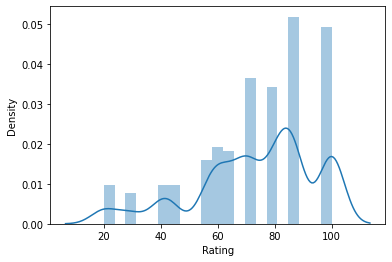

In [11]:
sns.distplot(df['Rating'])

**Определим функции предобработки текста, которые нам понадобятся в дальнейшем**

In [12]:
def tokenize(text: str, regex="[A-Za-z]+") -> list: # будем токенизировать с помощью регулярки
    regex = re.compile(regex)
    tokens = regex.findall(text.lower())

    return tokens

def remove_stopwords(
    lemmas, stopwords=stopwords.words("english")):
    """Returns list of lemmas without stopwords"""
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

@lru_cache(maxsize=128) # ускорим лемматизацию кэшированием 
def lemmatize_word(token):
    """Returns lemma"""
    pymorphy = MorphAnalyzer()
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    """Returns list of lemmas"""
    return [lemmatize_word(w) for w in text]

def clean_text(text):
    """Returns list of lemmas without stopwords"""
    tokens = tokenize("".join(text))
    lemmas = lemmatize_text(tokens)

    return remove_stopwords(lemmas)


In [13]:
clean_text(df.Review_Text[0])

['excellent',
 'room',
 'exercise',
 'facility',
 'around',
 'atmosphere',
 'calm',
 'comfortable',
 'main',
 'dining',
 'room',
 'offers',
 'excellent',
 'food',
 'service',
 'avoid',
 'flying',
 'elephant',
 'restaurant',
 'stick',
 'main',
 'dining',
 'room']

In [14]:
df["Review"] = df['Review_Title'] + " " + df['Review_Text'] # объединим заголовок с комментарием для упрощения получения векторов

In [15]:
df

,Id,Hotel_name,Review_Title,Review_Text,Rating,Review
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe....
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites. Pricing...
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,"Good stay First of all nice & courteous staff,..."
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...
...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,The Residency Good Centrally located Hotel The...


In [16]:
from multiprocess import Pool # распараллелим процессы

def get_clean_text(df):
    with Pool(8) as p:
        review_lemmas = list(p.imap(clean_text, df))
    return review_lemmas


In [17]:
df['Review_lemmas'] = get_clean_text(df['Review'])
df['Review_lemmas'] = df['Review_lemmas'].apply(lambda x: " ".join(x))  # Поскольку нас ожидает векторизация,
                                                                        # то лучше иметь список со строками

In [18]:
#  Название отеля будем считать категориальным признаком

df['Hotel_id'] = (df['Hotel_name'].astype('category')
                    .cat.rename_categories([i for i in range(df['Hotel_name'].nunique())]).astype('int'))     

In [19]:
df

,Id,Hotel_name,Review_Title,Review_Text,Rating,Review,Review_lemmas,Hotel_id
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...,refuge chennai excellent room exercise facilit...,139
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe....,hilton chennai comfortable felt safe staff hel...,73
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites. Pricing...,worth rating shown websites pricing worth rati...,219
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,"Good stay First of all nice & courteous staff,...",good stay first nice courteous staff stay time...,161
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...,needs improvement overall ambience hotel good ...,139
...,...,...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...,hyatt regency chennai impressive service staff...,81
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...,homely villa woodlands chennai gave homely exp...,120
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...,nice accommodation facilities awesome liked ne...,170
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,The Residency Good Centrally located Hotel The...,residency good centrally located hotel overall...,217


**Воспользуемся самими стандартными стилометрическими методами -- словарями тональности, которые по благословлению преподавателей лежат тут же**

In [20]:
negw_file = open("negative-words.txt", 'r')
posw_file = open("positive-words.txt", 'r')
pos_wordlist = [w.rstrip('\n') for w in posw_file.readlines()] 
neg_wordlist = [w.rstrip('\n') for w in negw_file.readlines()] 
negw_file.close()
posw_file.close()

In [21]:
def emotions_words_ratio(lst):
    neg_words = 0
    pos_words = 0
    for word in lst:
        if word in neg_wordlist:
            neg_words += 1
        elif word in pos_wordlist:
            pos_words += 1
    if len(lst):
        return [pos_words / len(lst), neg_words / len(lst)]
    else:
        return [0.0, 0.0]

In [22]:
df["Positive_words_ratio"], df["Negative_words_ratio"] = zip(*df["Review_lemmas"].apply(lambda x: emotions_words_ratio(x)))

**Давайте добавим ещё длину комментария**

In [23]:
df['Review_length'] = df["Review_lemmas"].apply(lambda x: len(x))

In [24]:
df

,Id,Hotel_name,Review_Title,Review_Text,Rating,Review,Review_lemmas,Hotel_id,Positive_words_ratio,Negative_words_ratio,Review_length
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...,refuge chennai excellent room exercise facilit...,139,0.0,0.0,185
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe....,hilton chennai comfortable felt safe staff hel...,73,0.0,0.0,141
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites. Pricing...,worth rating shown websites pricing worth rati...,219,0.0,0.0,224
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,"Good stay First of all nice & courteous staff,...",good stay first nice courteous staff stay time...,161,0.0,0.0,151
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...,needs improvement overall ambience hotel good ...,139,0.0,0.0,184
...,...,...,...,...,...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...,hyatt regency chennai impressive service staff...,81,0.0,0.0,266
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...,homely villa woodlands chennai gave homely exp...,120,0.0,0.0,278
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...,nice accommodation facilities awesome liked ne...,170,0.0,0.0,185
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,The Residency Good Centrally located Hotel The...,residency good centrally located hotel overall...,217,0.0,0.0,118


**Выгрузим наш тестовый датасет и предобработаем**

In [25]:
df2 = pd.read_csv('test.csv', encoding="ISO-8859-1")
df2.dropna(inplace=True) # Пусть датасет у нас скрытые данные, поэтому в пайплайне мне кажется логичным выкидывать всё сомнительное
df2.reset_index(drop=True, inplace=True)
df2

,Id,Hotel_name,Review_Title,Review_Text
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...
1,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...
2,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...
3,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ..."
4,2356,Mahalaya Residency,Good stay,It was a fantastic stay in the hotel. The staf...
...,...,...,...,...
2138,4696,The Residency Towers,Awesome experience,I will definitely stay this hotel on my next v...
2139,4698,Lemon Tree Chennai,Average stay,"Compared to other lemon tree stay, this was bi..."
2140,4699,Oyo Rooms T Nagar Off Pondy Bazaar,location is not good. rude behavior. staff no ...,unpleasant stay. not easy task to reach. Morni...
2141,4701,The Park Chennai,Over rated and overpriced Hotel,I am not sure why someone wants to spend that ...


In [26]:
df2["Review"] = df2['Review_Title'] + " " + df2['Review_Text'] 
df2['Review_lemmas'] = get_clean_text(df2['Review'])
df2['Review_lemmas'] = df2['Review_lemmas'].apply(lambda x: " ".join(x))
df2['Hotel_id'] = (df2['Hotel_name'].astype('category')
                    .cat.rename_categories([i for i in range(df2['Hotel_name'].nunique())]).astype('int'))
df2["Positive_words_ratio"], df2["Negative_words_ratio"] = zip(*df2["Review_lemmas"].apply(lambda x: emotions_words_ratio(x)))
df2['Review_length'] = df2["Review_lemmas"].apply(lambda x: len(x))

In [27]:
df2


,Id,Hotel_name,Review_Title,Review_Text,Review,Review_lemmas,Hotel_id,Positive_words_ratio,Negative_words_ratio,Review_length
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...,Mr Neeraj On the night of my arrival from NY I...,neeraj night arrival minor problem room neeraj...,83,0.0,0.0,192
1,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...,Nice stay for corporate people Been a good pla...,nice stay corporate people good place stay peo...,131,0.0,0.0,232
2,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...,Average hotel Not worth of the money we paid.w...,average hotel worth money paid worst water cle...,122,0.0,0.0,57
3,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ...",A good mid range corporate hotel A well locate...,good range corporate hotel well located hotel ...,157,0.0,0.0,216
4,2356,Mahalaya Residency,Good stay,It was a fantastic stay in the hotel. The staf...,Good stay It was a fantastic stay in the hotel...,good stay fantastic stay hotel staff good coop...,98,0.0,0.0,142
...,...,...,...,...,...,...,...,...,...,...
2138,4696,The Residency Towers,Awesome experience,I will definitely stay this hotel on my next v...,Awesome experience I will definitely stay this...,awesome experience definitely stay hotel next ...,216,0.0,0.0,145
2139,4698,Lemon Tree Chennai,Average stay,"Compared to other lemon tree stay, this was bi...",Average stay Compared to other lemon tree stay...,average stay compared lemon tree stay disappoi...,93,0.0,0.0,80
2140,4699,Oyo Rooms T Nagar Off Pondy Bazaar,location is not good. rude behavior. staff no ...,unpleasant stay. not easy task to reach. Morni...,location is not good. rude behavior. staff no ...,location good rude behavior staff help unpleas...,134,0.0,0.0,130
2141,4701,The Park Chennai,Over rated and overpriced Hotel,I am not sure why someone wants to spend that ...,Over rated and overpriced Hotel I am not sure ...,rated overpriced hotel sure someone wants spen...,211,0.0,0.0,71


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Посмотрим на качество сначала на нашем тренировочном датасете, разделив его на train-test**

In [29]:
tfidf = TfidfVectorizer(ngram_range=(2, 3))
X_train, X_test, y_train, y_test = train_test_split((df.iloc[:, 6:]), df['Rating'], test_size=0.2, random_state=42)

**Будем ансамблировать модель, обученную на тексте (мы выбрали TFIDF вектор) и на числовых признаках**

In [30]:
X_train_num, X_test_num = X_train.drop("Review_lemmas", axis=1), X_test.drop("Review_lemmas", axis=1)
X_train_text, X_test_text = tfidf.fit_transform(X_train['Review_lemmas']), tfidf.transform(X_test['Review_lemmas'])

In [31]:
linreg = LinearRegression()
linreg2 = LinearRegression()

linreg.fit(X_train_num, y_train)
linreg2.fit(X_train_text, y_train)

LinearRegression()

In [32]:
rmse_num = mean_squared_error(y_test, linreg.predict(X_test_num)) ** 0.5
rmse_text = mean_squared_error(y_test, linreg2.predict(X_test_text)) ** 0.5

In [33]:
print("RMSE on numeric features ", rmse_num) 
print("RMSE on TFIDF vectors ", rmse_text)
print("RMSE mean", (rmse_num + rmse_text) / 2)

RMSE on numeric features  21.1833880751143
RMSE on TFIDF vectors  15.478872821956562
RMSE mean 18.331130448535433


**Получили неплохой результат, который можно улучшать перебирая модели и их гиперпараметры, а также добавив ещё текстовых признаков (уровень лексики, разные индексы readability итд)**

In [34]:
X_train_num, X_test_num = df.iloc[:, 7:], df2.iloc[:, 6:]
X_train_text, X_test_text = tfidf.fit_transform(df['Review_lemmas']), tfidf.transform(df2['Review_lemmas'])
y_train = df['Rating']

In [35]:
linreg3 = LinearRegression()
linreg4 = LinearRegression()

linreg3.fit(X_train_num, y_train)
linreg4.fit(X_train_text, y_train)

LinearRegression()

In [36]:
linreg3.predict(X_test_num)
linreg4.predict(X_test_text)

array([100.00000002,  71.2612334 ,  47.05091506, ...,  69.9699471 ,
        40.00000001,  80.00000003])

**Имеели бы метки, получили, я уверен, ещё бы более впечатляющий результат, даже без тюнинга моделей**